## Student Name: Feiyang Li

## Student ID: 23202564

# Imports

You should not import any further functionality. If you feel this is required to complete the task, please discuss with your moderator.

In [1]:
!pip install scikit_optimize

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, learning_curve
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# imported to keep track of compute time if you wish
import sys
np.set_printoptions(threshold=sys.maxsize)
import time

In [3]:
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import confusion_matrix, accuracy_score
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Provided code
The below code is not necessarily complete or applicable to all tasks. Read and understand the code so that you can use wisely and adapt as required.

In [4]:
def plot_margin(X, y, clf):
    plt.figure(figsize=(10,6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)


    # plot the decision function
    ax = plt.gca()
    #ax.set_aspect(aspect=1)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')

To compare the SVM with a NN:

In [5]:
def plot_decisions(X, y, model):
    plt.figure(figsize=(10,6))
    # define bounds of the domain
    min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
    min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
    # define the x and y scale
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)
    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    yhat = model.predict(grid)
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    # plot the grid of x, y and z values as a surface
    plt.contourf(xx, yy, zz, cmap='Paired')
    # create scatter plot for samples from each class
    for class_value in range(2):
        # get row indexes for samples with this class
        row_ix = np.where(y == class_value)
        # create scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')

In [6]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    #plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_errors = 1- train_scores
    test_errors = 1-test_scores

    train_errors_mean = np.mean(train_errors, axis=1)
    train_errors_std = np.std(train_errors, axis=1)
    test_errors_mean = np.mean(test_errors, axis=1)
    test_errors_std = np.std(test_errors, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_errors_mean - train_errors_std,
                     train_errors_mean + train_errors_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_errors_mean - test_errors_std,
                     test_errors_mean + test_errors_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_errors_mean, 'o-', color="r",
             label="Training error")
    plt.plot(train_sizes, test_errors_mean, 'o-', color="g",
             label="Test error")


    plt.legend(loc="best")
    return plt

This wrapper is required in below BayesSearchCV for a neural network to combine the two layer arguments (or more if you wish to experiment with more than two layers) into the single hidden_layer_sizes hyper-parameter.

In [7]:
class MLPWrapper(BaseEstimator, ClassifierMixin):

    def __init__(self, layer1=10, layer2=10):
        self.layer1 = layer1
        self.layer2 = layer2

    def fit(self, X, y):
        model = MLPClassifier(
            hidden_layer_sizes=[self.layer1, self.layer2],
            max_iter = 1000,
        )
        model.fit(X, y)
        self.model = model
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.score(X, y)

In [8]:
# Example use of BayesSearchCV to search a large search space whilst keeping compute requirements in check

optSVM1_lin = BayesSearchCV(
    svm.SVC(),
    {
      'C': Real(1e-3, 1e+3, prior='log-uniform'),
        'kernel': Categorical(['linear']),
    },
    n_iter=100,
)

In [9]:
# Example use of BayesSearchCV with the MLPWrapper to vary the layer sizes

optNN1 = BayesSearchCV(
    estimator=MLPWrapper(),
    search_spaces={
        'layer1': Integer(1, 100),
        'layer2': Integer(1, 100)
    },
    n_iter=100,
)

# Solutions

## Task 1

In [10]:
data = np.loadtxt('dataset_1_train.csv', delimiter=',', skiprows=1)

In [11]:
X = data[:, :-1]
y = data[:, -1]

for row in data[:5]:
    print(row)


[-1.39389488 -1.37378992  0.        ]
[-0.37956815  1.40482855  0.        ]
[ 1.52572205 -1.71337933  1.        ]
[ 1.44418058 -0.62254835  1.        ]
[ 1.10889654 -1.45643257  1.        ]


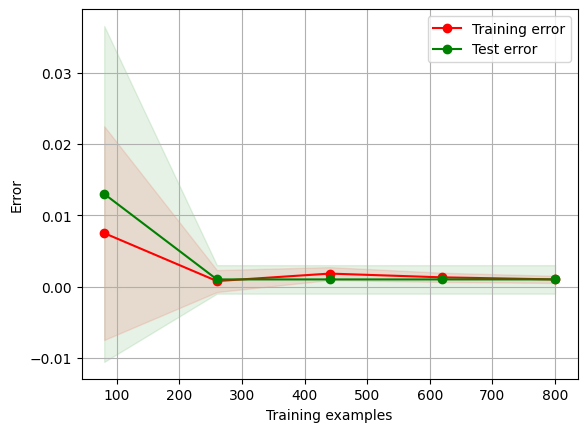

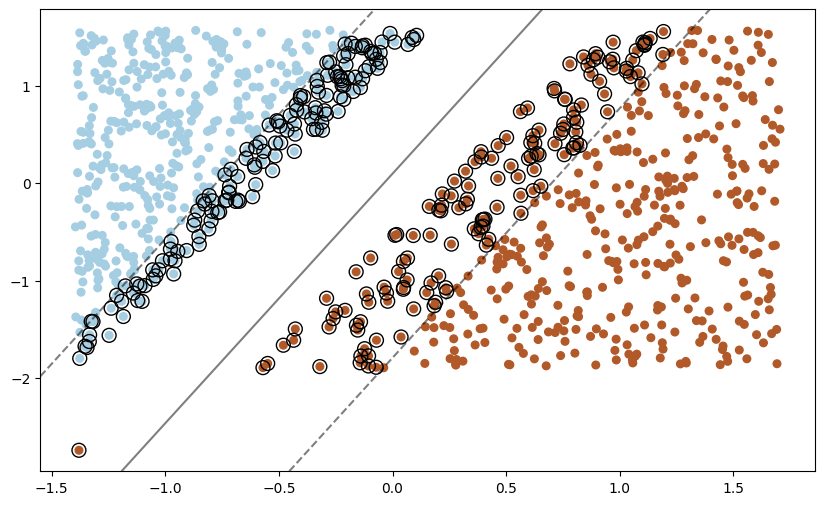

In [12]:
clf_soft = svm.SVC(kernel='linear', C=0.01)
clf_soft.fit(X, y)

plot_learning_curve(clf_soft,"c=0.01", X, y).show()

plot_margin(X, y, clf_soft)
soft_margin_support_vectors = len(clf_soft.support_vectors_)
soft_margin_accuracy = clf_soft.score(X, y)

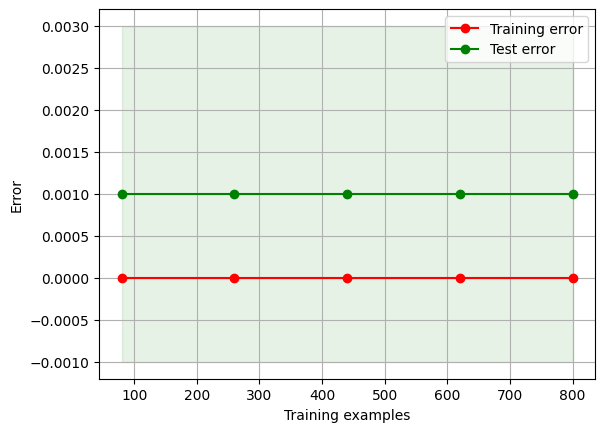

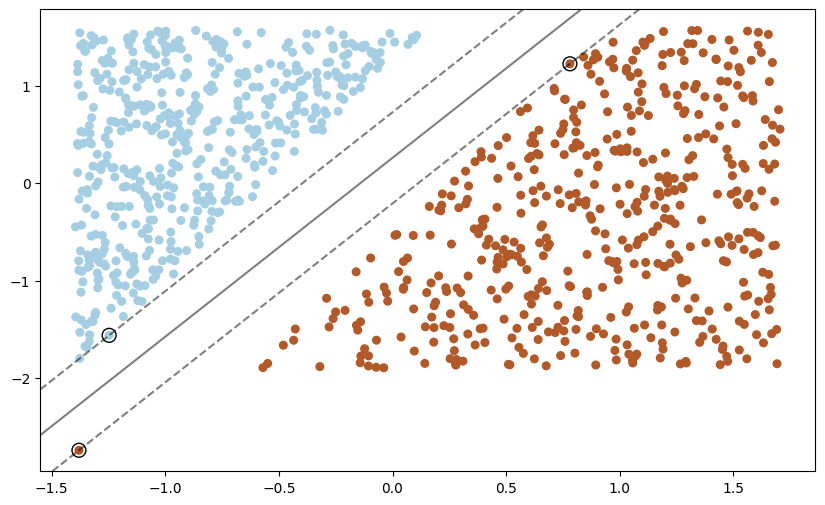

In [13]:
clf_hard = svm.SVC(kernel='linear', C=1000)
clf_hard.fit(X, y)

plot_learning_curve(clf_hard,"c=1000", X, y).show()

plot_margin(X, y, clf_hard)
hard_margin_support_vectors = len(clf_hard.support_vectors_)
hard_margin_accuracy = clf_hard.score(X, y)

In [14]:
soft_margin_support_vectors, soft_margin_accuracy, hard_margin_support_vectors, hard_margin_accuracy

(282, 0.999, 3, 1.0)

- The soft-bound SVM model has 282 support vectors with 99.9% accuracy on the training set.
- The hard bounded SVM model has only 3 support vectors and achieves 100% accuracy on the training set.

### Reflection

These results support our previous conclusions from the graphs: smaller C-values (soft boundaries) allow the model to tolerate a certain level of classification error while maintaining a large spacing, which may help improve the model's ability to generalize to unseen samples. In contrast, larger C-values (hard boundaries) emphasize minimizing classification errors, resulting in fewer support vectors and tighter decision boundaries, which may exhibit higher accuracy on the training set but increase the risk of overfitting and may reduce the model's ability to generalize to new data.

## Task 2

In [15]:
data2_train = np.loadtxt('dataset_2_train.csv', delimiter=',')
data2_test = np.loadtxt('dataset_2_test.csv', delimiter=',')
data3_train = np.loadtxt('dataset_3_train.csv', delimiter=',')
data3_test = np.loadtxt('dataset_3_test.csv', delimiter=',')

print("Dataset 2 - Training Set:")
print(data2_train[:5])
print("\nDataset 2 - Test Set:")
print(data2_test[:5])
print("\nDataset 3 - Training Set:")
print(data3_train[:5])
print("\nDataset 3 - Test Set:")
print(data3_test[:5])


Dataset 2 - Training Set:
[[ 0.48976318 -1.31905896  1.        ]
 [ 1.21809108  0.02704083  1.        ]
 [-0.75668985 -0.83401863  1.        ]
 [-0.22576289  0.50061889  0.        ]
 [-1.46537112 -0.93270757  1.        ]]

Dataset 2 - Test Set:
[[ 1.65066304  1.48368445  1.        ]
 [-1.35823675 -0.45689923  0.        ]
 [ 1.50806978  1.61313444  1.        ]
 [ 0.77568203 -0.6483028   1.        ]
 [-1.26336035  0.3813452   0.        ]]

Dataset 3 - Training Set:
[[ 1.36576274 -0.85296845  0.        ]
 [ 1.53302475  0.93982811  0.        ]
 [-0.37723541 -0.56832803  1.        ]
 [ 1.13248782 -0.33936347  0.        ]
 [ 1.28209194 -0.36677919  0.        ]]

Dataset 3 - Test Set:
[[ 1.42964041  1.57345794  0.        ]
 [ 0.38857834  1.70428138  0.        ]
 [ 0.58905646 -0.48787516  1.        ]
 [ 1.2201303  -1.36146619  0.        ]
 [ 1.06502617  1.55921736  0.        ]]


### SVM:

In [16]:
X_train_2 = data2_train[:, :-1]
y_train_2 = data2_train[:, -1]
X_test_2 = data2_test[:, :-1]
y_test_2 = data2_test[:, -1]

In [17]:
def evaluateSVM(X_train, y_train, X_test, y_test, C, kernel):
    """
    Train the SVM model and show the accuracy and learning curve for a given combination of hyperparameters.

    Parameters.
    - x_train: training data features.
    - y_train: training data labels.
    - X_test: test data features. y_test: test data labels.
    - y_test: test data label.

    """
    # Create SVM model with given C and kernel
    model = svm.SVC(C=C, kernel=kernel)

    model.fit(X_train, y_train)

    accuracy = model.score(X_test, y_test)
    print(accuracy)

    plot_learning_curve(model, f"Learning curve - SVM with C = {C} and kernel = {kernel} with accuracy of {accuracy}", X, y)

#### data2

0.7311178247734139


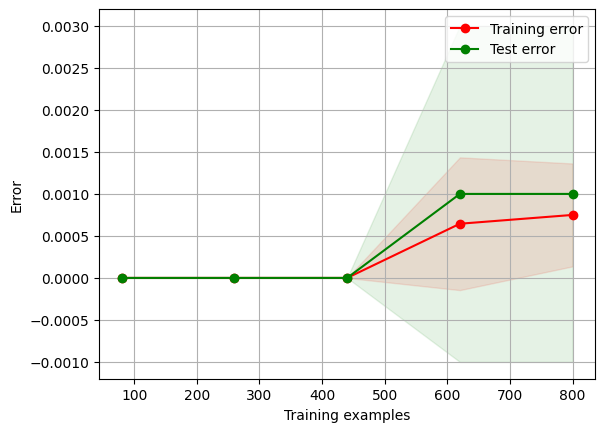

In [18]:
evaluateSVM(X_train_2, y_train_2, X_test_2, y_test_2, C=0.1, kernel='rbf')

0.7462235649546828


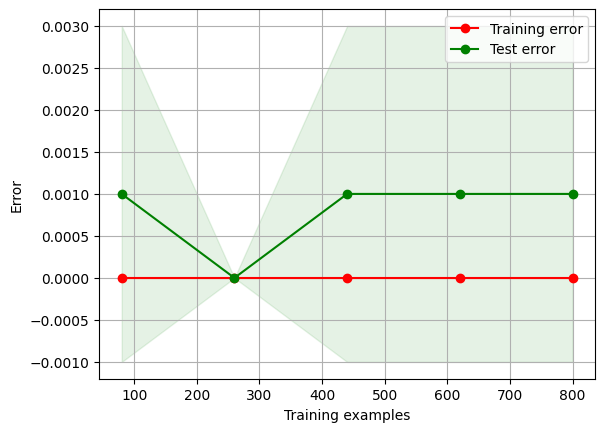

In [19]:
evaluateSVM(X_train_2, y_train_2, X_test_2, y_test_2, C=1, kernel='rbf')

0.7764350453172205


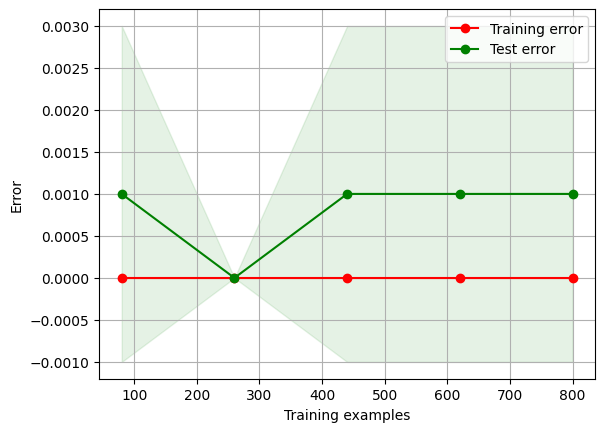

In [20]:
evaluateSVM(X_train_2, y_train_2, X_test_2, y_test_2, C=100, kernel='rbf')

0.6888217522658611


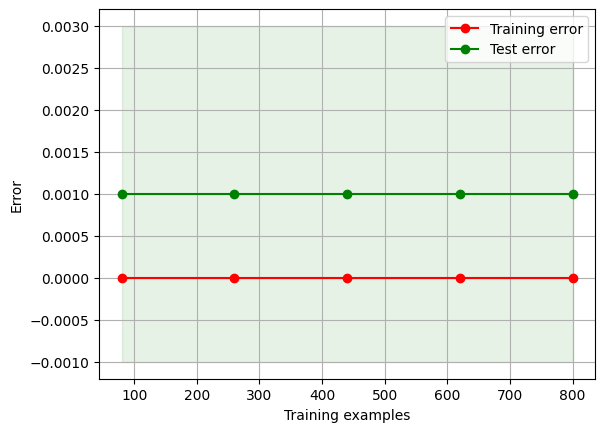

In [21]:
evaluateSVM(X_train_2, y_train_2, X_test_2, y_test_2, C=100, kernel='linear')

By exploring, the rbf kernel performs better than the linear kernel in dataset 2. And it performs best when c value is equal to 100.

The following parameters are optimized for dataset 2:

In [22]:
results = {}

kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in kernels:
    svc = svm.SVC(kernel=kernel)
    svc.fit(X_train_2, y_train_2)
    score = svc.score(X_test_2, y_test_2)
    results[kernel] = score

results

{'linear': 0.6888217522658611,
 'poly': 0.6827794561933535,
 'rbf': 0.7462235649546828,
 'sigmoid': 0.6737160120845922}

This result suggests that the RBF kernel is a more appropriate choice for dataset 2, which also implies that dataset 2 may not be linearly divisible and that better decision boundaries need to be found by mapping the data to a higher dimensional space using the RBF kernel.

In [23]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_2, y_train_2)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score


({'C': 100, 'gamma': 0.1}, 0.7671641791044777)

After hyperparameter tuning of the SVM with RBF kernel on dataset 2, I found that the optimal parameter combination is C=100 and gamma=0.1

In [24]:
# Evaluate model performance on a test set using optimal parameters
best_svc = svm.SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'])
best_svc.fit(X_train_2, y_train_2)
test_score = best_svc.score(X_test_2, y_test_2)

test_score


0.7643504531722054

The average accuracy on cross-validation is about 76.68%.

<ipython-input-5-0fe069eed736>:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


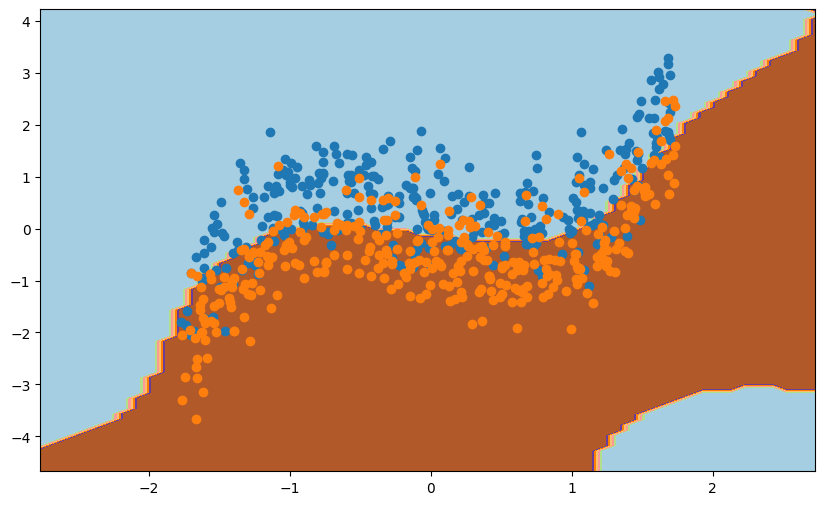

In [25]:
plot_decisions(X_train_2, y_train_2, best_svc)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

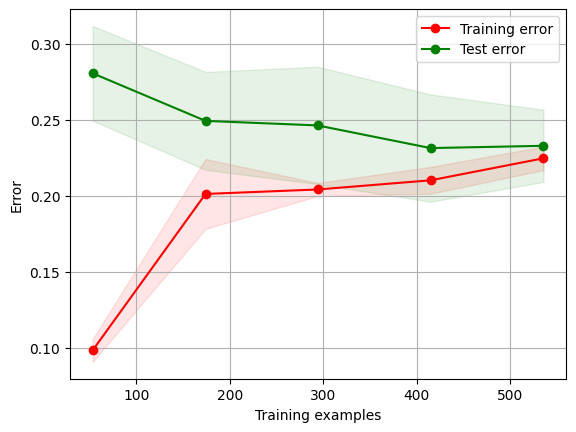

In [26]:
plot_learning_curve(best_svc,'',X_train_2,y_train_2)

#### data3

In [27]:
X_train_3 = data3_train[:, :-1]
y_train_3 = data3_train[:, -1]
X_test_3 = data3_test[:, :-1]
y_test_3 = data3_test[:, -1]

0.9818181818181818


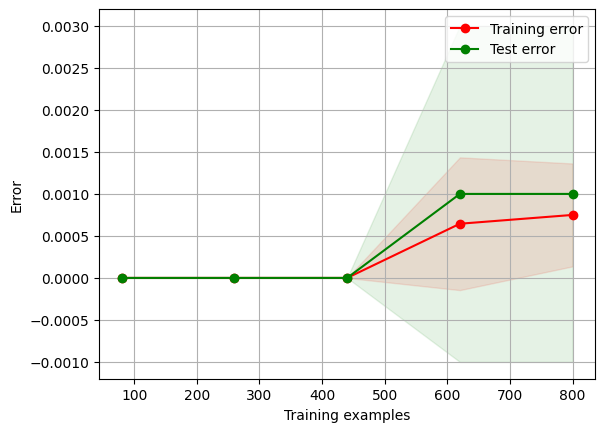

In [28]:
evaluateSVM(X_train_3, y_train_3, X_test_3, y_test_3, C=0.1, kernel='rbf')

0.9636363636363636


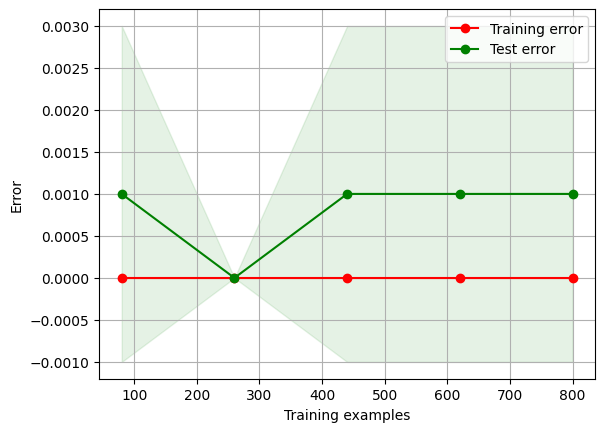

In [29]:
evaluateSVM(X_train_3, y_train_3, X_test_3, y_test_3, C=1, kernel='rbf')

0.9757575757575757


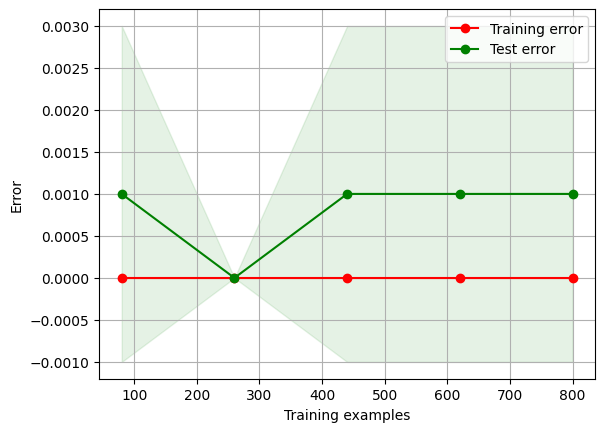

In [30]:
evaluateSVM(X_train_3, y_train_3, X_test_3, y_test_3, C=10, kernel='rbf')

0.8


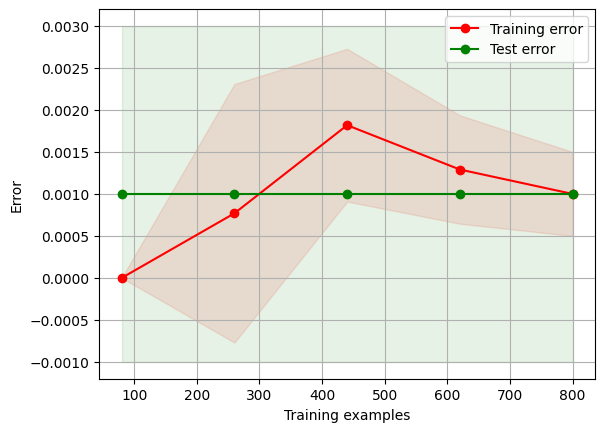

In [31]:
evaluateSVM(X_train_3, y_train_3, X_test_3, y_test_3, C=0.1, kernel='linear')

Through exploration it was found that the best performance was achieved when the c value was equal to 0.1 and the kernel was rbf.

Hyperparameter optimization:

In [32]:
results_3 = {}

for kernel in kernels:
    svc = svm.SVC(kernel=kernel)
    svc.fit(X_train_3, y_train_3)
    score = svc.score(X_test_3, y_test_3)
    results_3[kernel] = score

results_3

{'linear': 0.8,
 'poly': 0.8,
 'rbf': 0.9636363636363636,
 'sigmoid': 0.6606060606060606}

In [33]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_3, y_train_3)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

({'C': 10, 'gamma': 1}, 0.9671641791044777)

C=10 and gamma=1, the average accuracy on cross-validation is about 96.71%.

In [34]:
best_svc_3 = svm.SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'])
best_svc_3.fit(X_train_3, y_train_3)
test_score_3 = best_svc_3.score(X_test_3, y_test_3)

test_score_3

0.9575757575757575

<ipython-input-5-0fe069eed736>:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


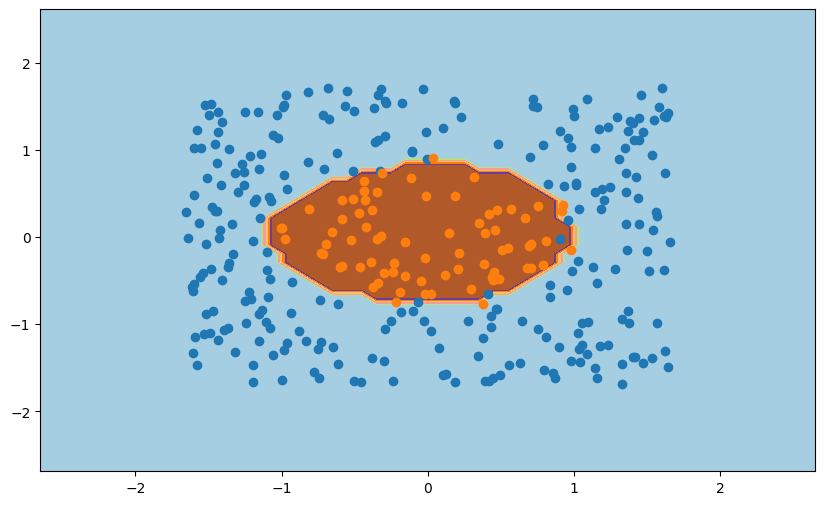

In [35]:
plot_decisions(X_train_3, y_train_3, best_svc_3)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

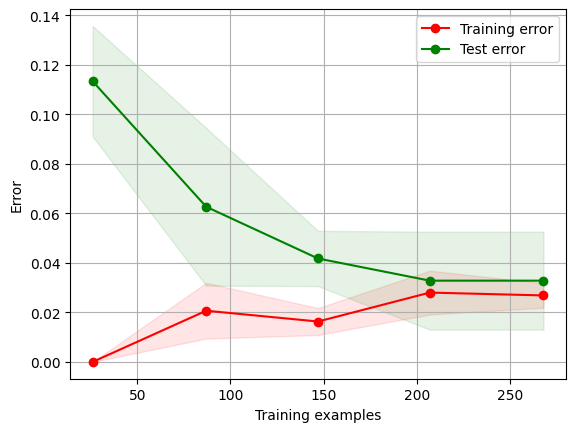

In [36]:
plot_learning_curve(best_svc_3,'',X_train_3,y_train_3)

### For dataset 2, the optimal hyperparameter combination is c=100, gamma=0.1, and kernel=rbf. For dataset 3, the optimal hyperparameter combination is c=10, gamma=1, and kernel=rbf.

### NN:

In [37]:
data2_train_shape = data2_train.shape
data2_test_shape = data2_test.shape
data3_train_shape = data3_train.shape
data3_test_shape = data3_test.shape

data2_train_shape, data2_test_shape, data3_train_shape, data3_test_shape

((670, 3), (331, 3), (335, 3), (165, 3))

In [38]:
def preprocess(data):
    X = data[:, :-1]
    y = data[:, -1]
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    return X_scaled, y

X2_train, y2_train = preprocess(data2_train)
X2_test, y2_test = preprocess(data2_test)
X3_train, y3_train = preprocess(data3_train)
X3_test, y3_test = preprocess(data3_test)

In [39]:
hyperparameters = [
    {'hidden_layer_sizes': (50,), 'activation': 'relu', 'learning_rate_init': 0.001},
    {'hidden_layer_sizes': (100,), 'activation': 'relu', 'learning_rate_init': 0.001},
    {'hidden_layer_sizes': (50, 50), 'activation': 'relu', 'learning_rate_init': 0.001},
    {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'learning_rate_init': 0.001},
    {'hidden_layer_sizes': (50,), 'activation': 'relu', 'learning_rate_init': 0.01},
]

In [40]:
results = []
for params in hyperparameters:
    model = MLPClassifier(max_iter=1000, **params)
    scores = cross_val_score(model, X2_train, y2_train, cv=3)
    results.append({'params': params, 'score': scores.mean()})

In [41]:
for result in results:
    print(f"params: {result['params']}, score: {result['score']}")

params: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'learning_rate_init': 0.001}, score: 0.7701126414691437
params: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'learning_rate_init': 0.001}, score: 0.7566864189622038
params: {'hidden_layer_sizes': (50, 50), 'activation': 'relu', 'learning_rate_init': 0.001}, score: 0.7641402412983131
params: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'learning_rate_init': 0.001}, score: 0.7268244181080504
params: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'learning_rate_init': 0.01}, score: 0.7701326606875935


In [42]:
def evaluate_model(hyperparameters, X_train, y_train, X_test, y_test, cv=3, n_jobs=-1):
    """
    Train the model and show the decision bounds and learning curves for a given combination of hyperparameters.

    Parameters.
    - hyperparameters: dict, hyperparameter combination.
    - x_train: training data features.
    - y_train: label of training data.
    - cv: cross validation folds.
    - n_jobs: number of parallel jobs.
    """
    model = MLPClassifier(max_iter=1000, **hyperparameters)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    plot_decisions(X_train, y_train, model)

    title = "Learning Curve (MLPClassifier)"
    plot_learning_curve(model, title, X_train, y_train, cv=cv, n_jobs=n_jobs)


#### data2

##### One hidden layer with fifty neurons. The activation function is ReLU. initial learning rate is 0.001.

Accuracy: 0.7583


<ipython-input-5-0fe069eed736>:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


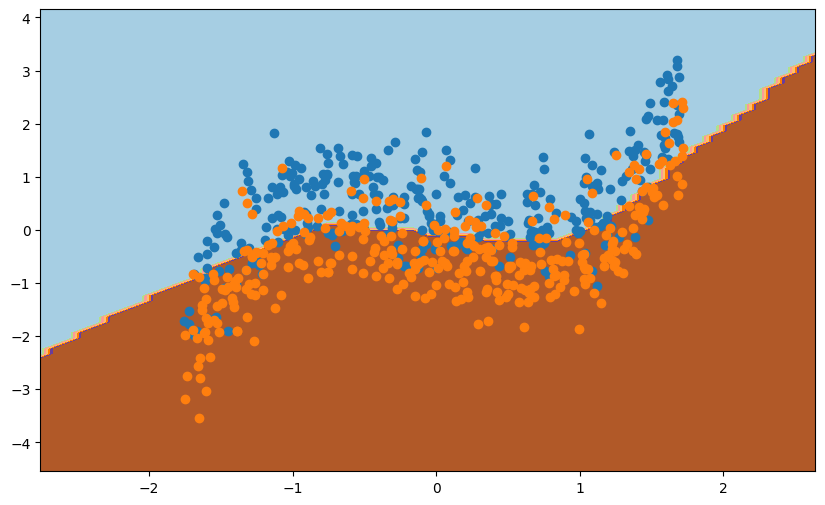

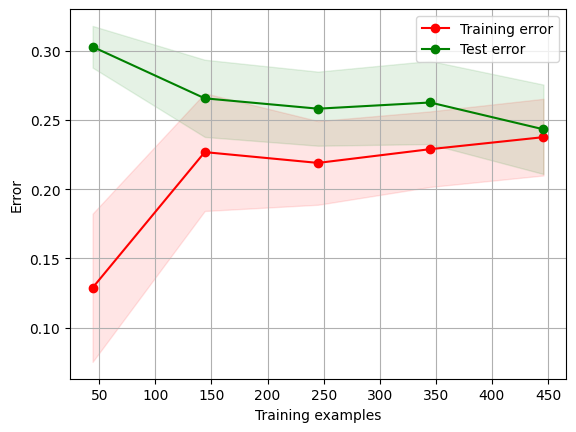

In [43]:
params_1 = hyperparameters[0]
evaluate_model(params_1, X2_train, y2_train, X2_test, y2_test)

##### One hidden layer with one hundred neurons. The activation function is ReLU. initial learning rate is 0.001.

Accuracy: 0.7583


<ipython-input-5-0fe069eed736>:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


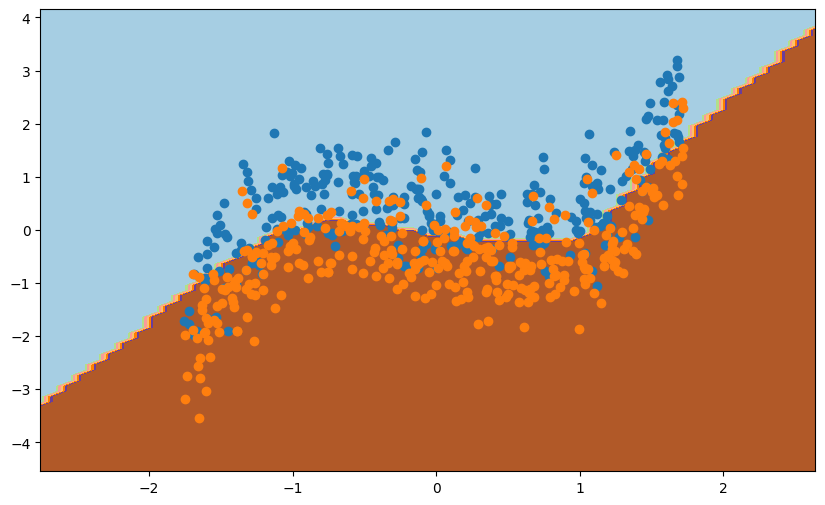

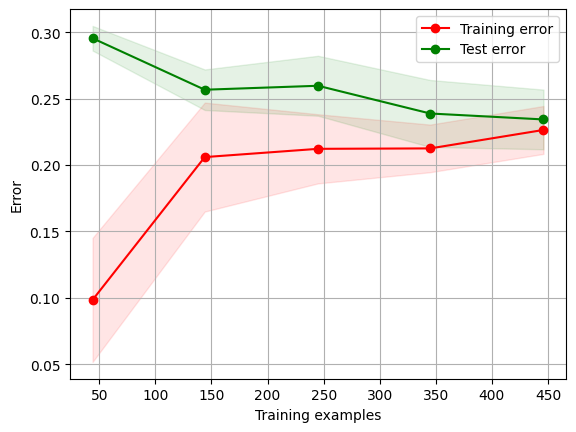

In [44]:
params_2 = hyperparameters[1]
evaluate_model(params_2, X2_train, y2_train, X2_test, y2_test)

##### Two hidden layers with fifty neurons per layer. The activation function is ReLU. the initial learning rate is 0.001.

Accuracy: 0.7674


<ipython-input-5-0fe069eed736>:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


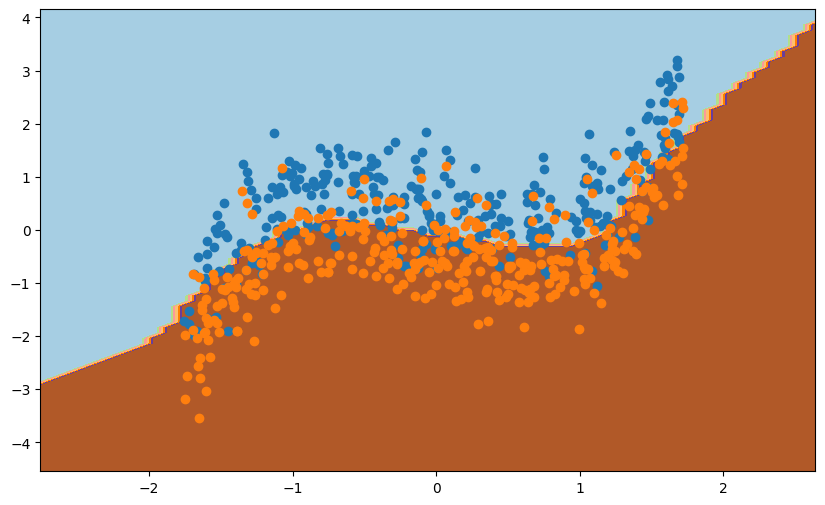

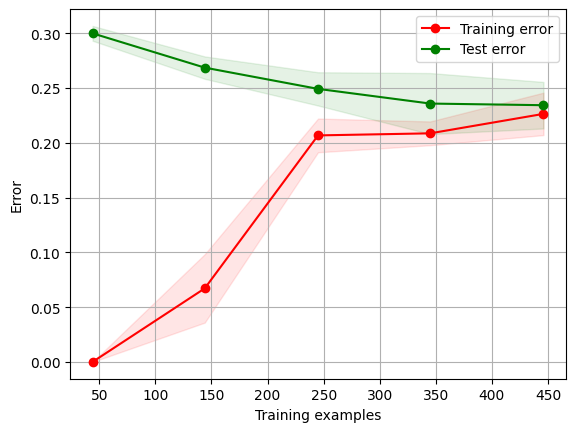

In [45]:
params_3 = hyperparameters[2]
evaluate_model(params_3, X2_train, y2_train, X2_test, y2_test)

##### One hidden layer with one hundred neurons. The activation function is tanh. the initial learning rate is 0.001.

Accuracy: 0.6949


<ipython-input-5-0fe069eed736>:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


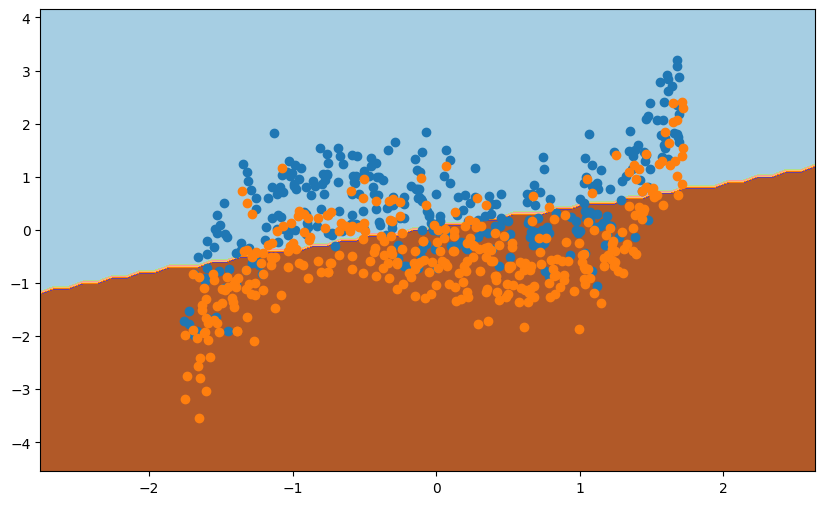

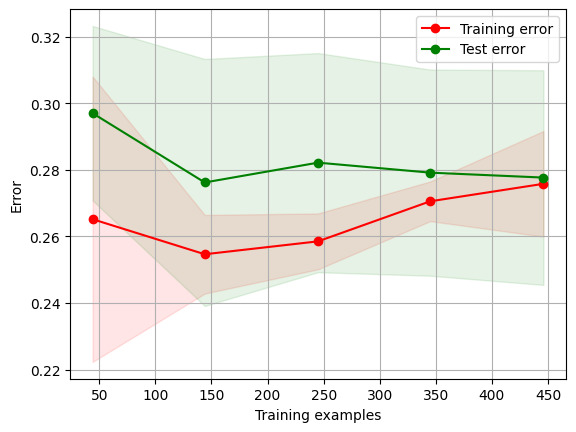

In [46]:
params_4 = hyperparameters[3]
evaluate_model(params_4, X2_train, y2_train, X2_test, y2_test)

##### One hidden layer with fifty neurons. The activation function is ReLU. initial learning rate is 0.01.

Accuracy: 0.7734


<ipython-input-5-0fe069eed736>:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


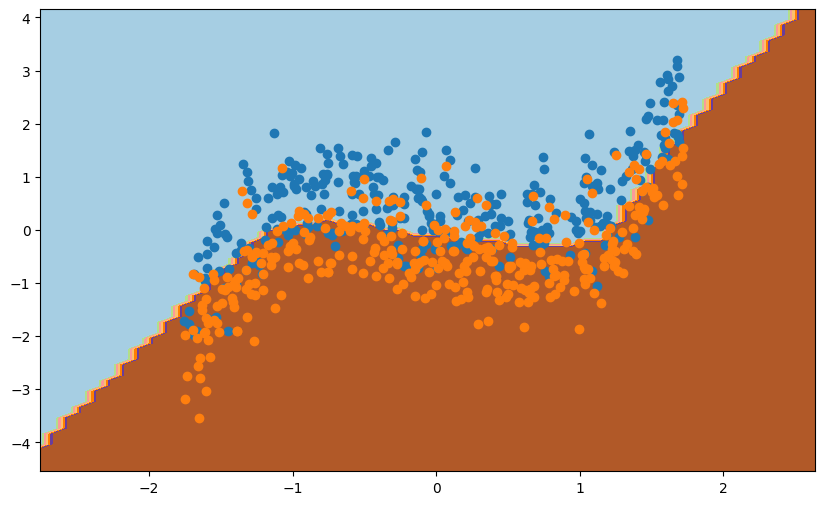

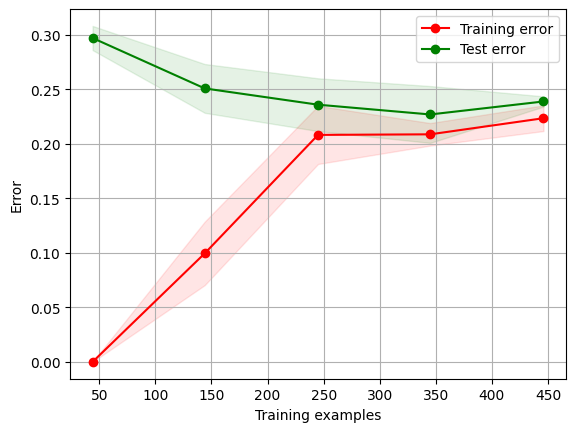

In [47]:
params_5 = hyperparameters[4]
evaluate_model(params_5, X2_train, y2_train, X2_test, y2_test)

#### By looking at the images it can be seen that relu outperforms the tanh function on dataset 2. The best model is when two hidden layers are set up with fifty neurons per layer and an initial learning rate of 0.001.

#### data3

##### One hidden layer, fifty neurons. The activation function is ReLU. initial learning rate is 0.001.

Accuracy: 0.9818


<ipython-input-5-0fe069eed736>:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


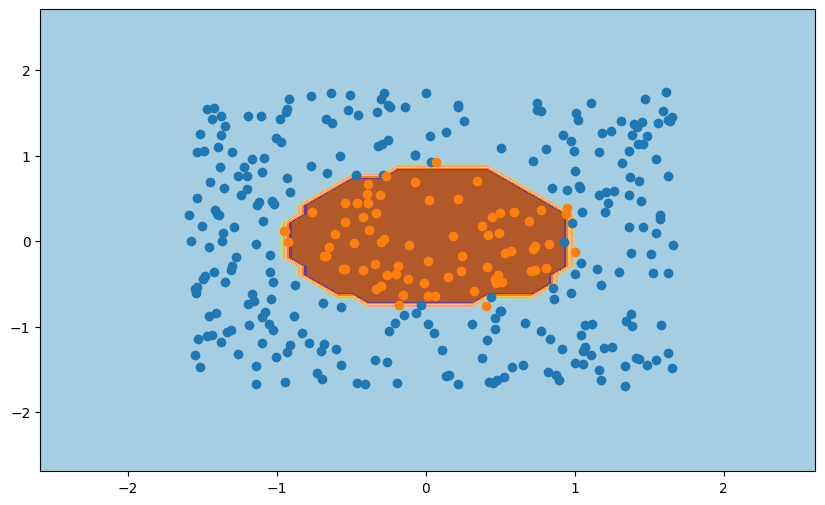

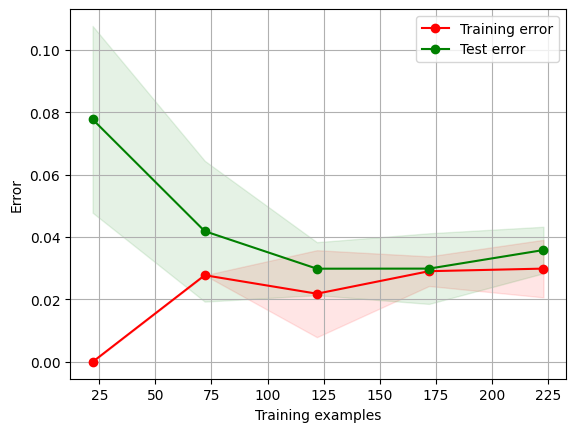

In [48]:
params3_1 = hyperparameters[0]
evaluate_model(params3_1, X3_train, y3_train, X3_test, y3_test)

##### One hidden layer with one hundred neurons. The activation function is ReLU. initial learning rate is 0.001.

Accuracy: 0.9879


<ipython-input-5-0fe069eed736>:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


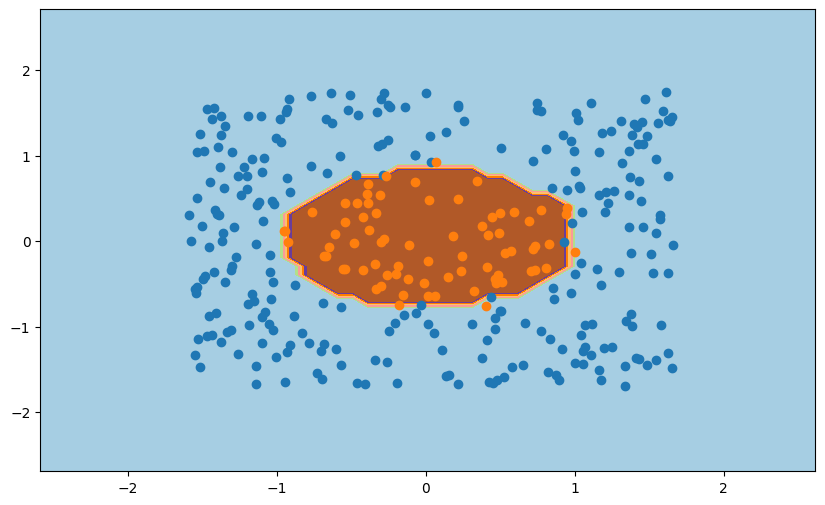

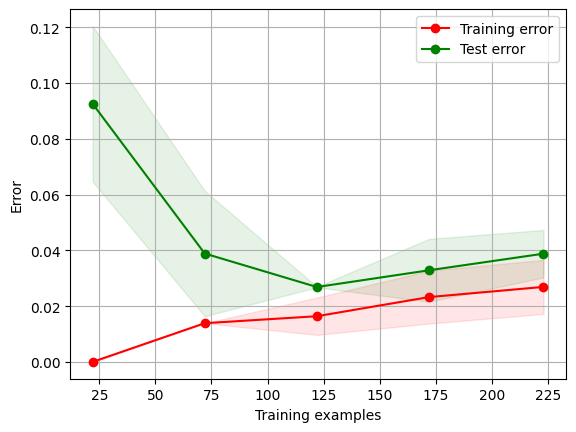

In [49]:
params3_2 = hyperparameters[1]
evaluate_model(params3_2, X3_train, y3_train, X3_test, y3_test)

##### Two hidden layers with fifty neurons per layer. The activation function is ReLU. initial learning rate is 0.001.

Accuracy: 0.9818


<ipython-input-5-0fe069eed736>:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


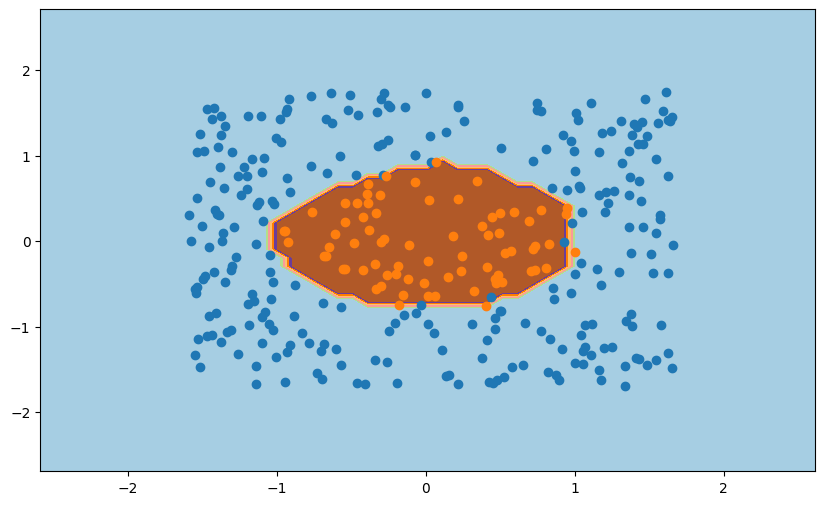

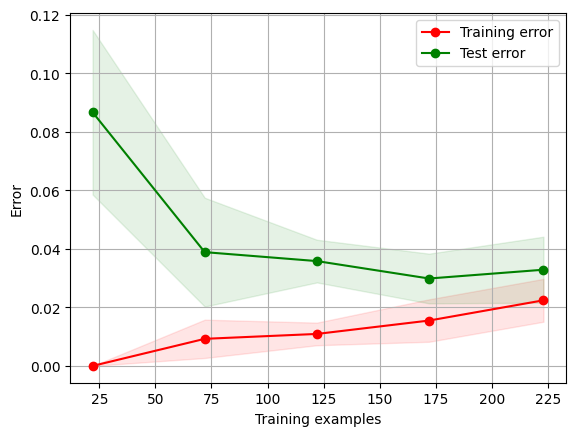

In [50]:
params3_3 = hyperparameters[2]
evaluate_model(params3_3, X3_train, y3_train, X3_test, y3_test)

##### One hidden layer with one hundred neurons. The activation function is tanh. initial learning rate is 0.001.

Accuracy: 0.9818


<ipython-input-5-0fe069eed736>:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


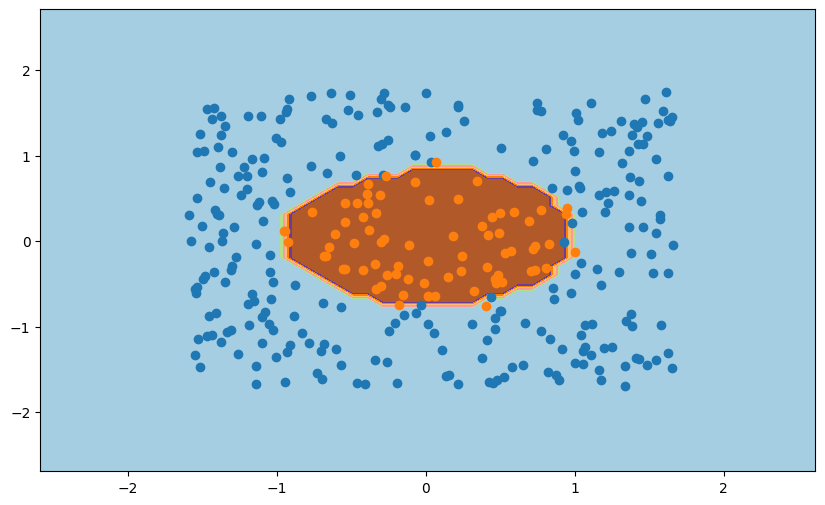

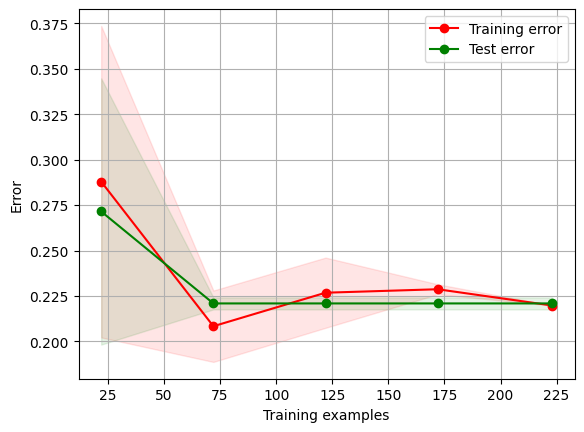

In [51]:
params3_4 = hyperparameters[3]
evaluate_model(params3_4, X3_train, y3_train, X3_test, y3_test)

##### One hidden layer with fifty neurons. The activation function is ReLU. initial learning rate is 0.01.

Accuracy: 0.9879


<ipython-input-5-0fe069eed736>:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


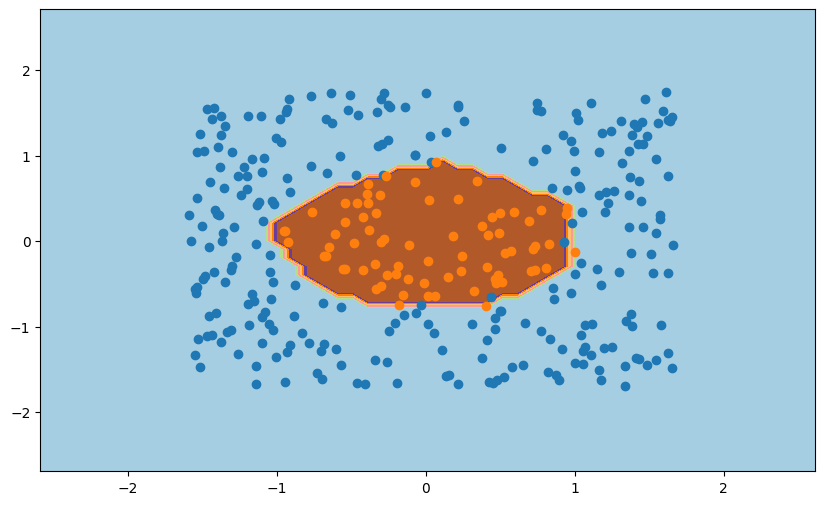

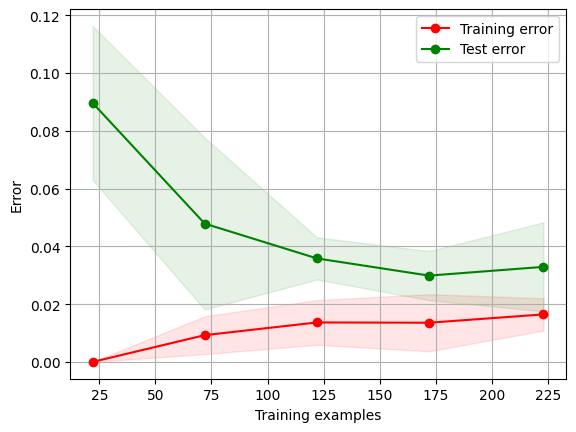

In [52]:
params3_5 = hyperparameters[4]
evaluate_model(params3_5, X3_train, y3_train, X3_test, y3_test)

#### ReLU still performs much better than the tanh function in Data 3. The optimal parameter setting is Two hidden layers with fifty neurons per layer.The activation function is ReLU. initial learning rate is 0.001.

#### Now Grid search is used for hyperparameter optimization of dataset.

In [53]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01],
}

grid_search = GridSearchCV(
    estimator=MLPClassifier(max_iter=1000),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=2
)

#### data2

In [54]:
grid_search.fit(X2_train, y2_train)

print("Best parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01}
Best Score:  0.7686378923766816


#### data3

In [55]:
grid_search.fit(X3_train, y3_train)

print("Best parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01}
Best Score:  0.9730802230802231


### Reflection


The best combination of parameters in svm, found through my own explorations, is:  
Dataset 2: C=100, kernel=rbf  Score: 77.7%
Dataset 3: C=10, kernel=rbf  Score:98.2%
  
The best combination of parameters found through parameter optimization is:  
Dataset 2: C=100, gamma=0.1, kernel=rbf Score:76.7%
Dataset 3: C=10, gamma=1, kernel=rbf score:96.7%

The best combination of parameters found by own exploration in NN is:  
Dataset 2: One hidden layer with fifty neurons. The activation function is ReLU. initial learning rate is 0.01.   score:77.34%
Dataset 3: The activation function is ReLU. initial learning rate is 0.001. Score: 98.18%
  
    
The best combination of parameters found by parameter optimization is:  
Dataset 2: activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01 score: 76.9%
Dataset 3: 'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01 score:97.3%